# Brain Tumor Segmentation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from UNetPPDataGenerator import ImageDataGen
from UNetPP import UNetPlusPlus
from ImageDataExtractor import ImageDataExtractor

In [2]:
dataExtractor = ImageDataExtractor(RemoveTemporaryFiles = True)
MAT_DATA_PATH, IMG_DATA_PATH, MASK_DATA_PATH, DATA_README_PATH = dataExtractor.downloadAndExtractImages()

>>> Data already downloaded. Check the following directoies
-----------------------------------------------------------
>>> Mat files located @ 'data\matData'
>>> Image files located @ 'data\imgData\img'
>>> Mask files located @ 'data\imgData\mask'
>>> Data ReadMe located @ 'data\README.txt'


In [3]:
MAT_DATA_PATH, IMG_DATA_PATH, MASK_DATA_PATH, DATA_README_PATH

('data\\matData',
 'data\\imgData\\img',
 'data\\imgData\\mask',
 'data\\README.txt')

In [4]:
image_size = 128
image_channels = 1
epochs = 30
batch_size = 64

# there are a total of 3064 images.
# so fixing 2900 of data available for training set
# 200 for validation set and 64 for test set.
validation_data_size = 200
test_data_size = 64
train_data_size = 2800

In [5]:
def VisualizeImageAndMask(image, mask, prediction_img = None):
    
    """
    
    Displays the image, mask and the predicted mask
    of the input image.
    
    Args:
        image: the original image.
        mask: the given mask of the image.
        prediction_img: the predicted mask of the image.
        
    Return:
        None
        
    """
    fig = plt.figure()
    fig.subplots_adjust(hspace = 0.6, wspace = 0.6)
    fig.suptitle('Image & Mask(s)', fontsize = 15)
    fig.subplots_adjust(top = 1.15)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(image, cmap = "gray")
    setTitleAndRemoveTicks(ax, 'Original\nImage')
    
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(mask, cmap = "gray")
    setTitleAndRemoveTicks(ax, 'Original\nMask')
    
    if prediction_img is not None:
        #prediction_img = prediction_img * 255
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(np.reshape(prediction_img, (image_size, image_size)), cmap = "gray")
        setTitleAndRemoveTicks(ax, 'Predicted\nMask')
    
def setTitleAndRemoveTicks(axes, title):
    
    """
    Sets the sub-plot title and removes the 
    x & y ticks on the respective axes.
    
    Args:
        axes: the subplot.
        title: title of the subplot.
        
    Return:
        None
        
    """
    
    # set plot title
    axes.title.set_text(title)
    
    # remove the ticks
    axes.set_xticks([])
    axes.set_yticks([])

In [6]:
# get the ids of the images.
# os.walk yields a 3-tuple (dirpath, dirnames, filenames). We need the directory names here.
IMG_DATA_PATH = 'data\\imgData\\img'
MASK_DATA_PATH = 'data\\imgData\\mask'
image_ids = next(os.walk(IMG_DATA_PATH))[2]
np.random.shuffle(image_ids)

# partition the data into train, test and validation sets.
testing_data_ids = image_ids[:test_data_size]
validation_data_ids = image_ids[:validation_data_size]
training_data_ids = image_ids[:train_data_size]

In [7]:
temp_data_generator = ImageDataGen(image_ids = training_data_ids,
                                   img_path = IMG_DATA_PATH, 
                                   mask_path = MASK_DATA_PATH,
                                   batch_size = batch_size, 
                                   image_size = image_size)

# get one batch of data
images, masks = temp_data_generator.__getitem__(0)
print("Batch Dimension Details:", images.shape, masks.shape)

Batch Dimension Details: (64, 128, 128) (64, 128, 128)


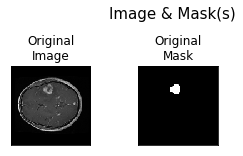

In [8]:
VisualizeImageAndMask(image = images[2], mask = masks[2])

In [9]:
temp_data_generator = None

### Model Training and Validation

#### Model Initialization

In [10]:
# Initialize the Unet++ with the default parameters. 
# The default params are the one that were used in the original paper.
# Input shape - (512, 512, 1), 
# filters [32, 64, 128, 256, 512].
UNetPP = UNetPlusPlus(input_shape = (128, 128, 1), deep_supervision = False)

# call the build netowrk API to build the network.
model = UNetPP.BuildNetwork()

In [11]:
# compile & summarize the model
if model is not None:
    UNetPP.CompileAndSummarizeModel(model = model)

Model: "UNetPP"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputLayer (InputLayer)         [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv00_1 (Conv2D)               (None, 128, 128, 32) 320         InputLayer[0][0]                 
__________________________________________________________________________________________________
X00_ (Dropout)                  (None, 128, 128, 32) 0           conv00_1[0][0]                   
__________________________________________________________________________________________________
conv00_2 (Conv2D)               (None, 128, 128, 32) 9248        X00_[0][0]                       
_____________________________________________________________________________________________

#### Initialize the Data Generators

In [12]:
train_gen = ImageDataGen(image_ids = training_data_ids,
                         img_path = IMG_DATA_PATH, 
                         mask_path = MASK_DATA_PATH, 
                         image_size = image_size, 
                         batch_size = batch_size)

valid_gen = ImageDataGen(image_ids = validation_data_ids, 
                         img_path = IMG_DATA_PATH, 
                         mask_path = MASK_DATA_PATH,
                         image_size = image_size, 
                         batch_size = batch_size)

test_gen = ImageDataGen(image_ids = testing_data_ids, 
                        img_path = IMG_DATA_PATH, 
                        mask_path = MASK_DATA_PATH,
                        image_size = image_size, 
                        batch_size = batch_size)

train_steps = len(training_data_ids)//batch_size
valid_steps = len(validation_data_ids)//batch_size

In [13]:
train_steps, valid_steps

(43, 3)

#### Model Training

In [14]:
model.fit(train_gen, 
          validation_data = valid_gen, 
          steps_per_epoch = train_steps, 
          validation_steps = valid_steps, 
          epochs = epochs)

Epoch 1/30
43/43 [==============================] - 1475s 34s/step - loss: 0.8190 - acc: 0.9503 - __iou_loss_core: 0.3295 - val_loss: 0.7801 - val_acc: 0.9845 - val___iou_loss_core: 0.6199
Epoch 2/30
43/43 [==============================] - 996s 23s/step - loss: 0.6874 - acc: 0.9751 - __iou_loss_core: 0.5616 - val_loss: 0.9808 - val_acc: 0.9908 - val___iou_loss_core: 0.8625
Epoch 3/30
43/43 [==============================] - 436s 10s/step - loss: 0.6622 - acc: 0.9765 - __iou_loss_core: 0.5827 - val_loss: 0.9737 - val_acc: 0.9858 - val___iou_loss_core: 0.8323
Epoch 4/30
43/43 [==============================] - 439s 10s/step - loss: 0.6355 - acc: 0.9794 - __iou_loss_core: 0.5995 - val_loss: 0.8686 - val_acc: 0.9812 - val___iou_loss_core: 0.7302
Epoch 5/30
43/43 [==============================] - 451s 10s/step - loss: 0.6235 - acc: 0.9789 - __iou_loss_core: 0.5944 - val_loss: 0.9985 - val_acc: 0.9843 - val___iou_loss_core: 0.8677
Epoch 6/30
43/43 [==============================] - 436s 10

#### Save the Model

In [15]:
model_dir = "models"
model_name = "UNetpp_BrainTumorSegment.h5"

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

model.save_weights(os.path.join(model_dir, model_name))

In [25]:
test_gen = ImageDataGen(image_ids = testing_data_ids, 
                        img_path = IMG_DATA_PATH, 
                        mask_path = MASK_DATA_PATH,
                        image_size = image_size, 
                        batch_size = 32)

### Model Testing and Prediction Visualizations

In [28]:
# get the test set images
test_images, test_masks = test_gen.__getitem__(0)
predicted_masks = model.predict(test_images)

predicted_masks = predicted_masks > 0.5

In [29]:
test_images_2, test_masks_2 = test_gen.__getitem__(1)
predicted_masks_2 = model.predict(test_images)

predicted_masks_ = predicted_masks_2 > 0.5

#### Viz 1

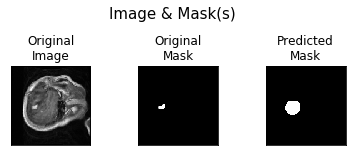

In [37]:
VisualizeImageAndMask(image = test_images_2[4], mask = test_masks_2[4], prediction_img = predicted_masks_[4])

#### Viz 2

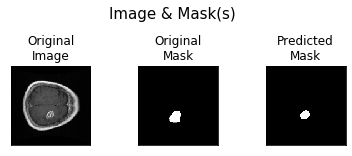

In [33]:
VisualizeImageAndMask(image = test_images[3], mask = test_masks[3], prediction_img = predicted_masks[3])

#### Viz 3

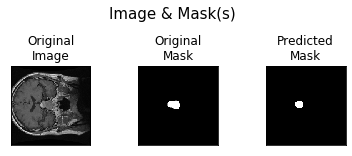

In [34]:
VisualizeImageAndMask(image = test_images[22], mask = test_masks[22], prediction_img = predicted_masks[22])

### Conclusion & Summary

Comparing the microscopic image, original mask and the predicted mask, the model based on the UNet++ architecture is correctly able to segment the cell nuclei and generate the masks.

#### Summary
- UNet++ aims to improve segmentation accuracy, with a series of nested, dense skip pathways.
- Redesigned skip pathways make optimization easier by getting the semantically similar feature maps.
- Dense skip connections improve segmentation accuracy and make the gradient flow smoother.
- Deep supervision allows for model complexity tuning to balance between speed and performance optimisation by allowing the model to toggle between 2 different training modes in the fast mode and the accurate mode.